# TOP

In [1]:
%reset -f
import ROOT

ROOT.gStyle.SetOptFit(1)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetGridColor(16)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)
ROOT.gStyle.SetPadRightMargin(0.05)
ROOT.gStyle.SetPadLeftMargin(0.09)
ROOT.gStyle.SetPadBottomMargin(0.11)
ROOT.gStyle.SetTitleSize(0.075, 'XY')
ROOT.gStyle.SetLabelSize(0.07, 'XY')
ROOT.gStyle.SetTitleOffset(0.8, 'X')
ROOT.gStyle.SetTitleOffset(0.65, 'Y')
ROOT.gStyle.SetMarkerSize(2)

%run -i ../eppi0_columns.py


fname="../data/lvl2_eppi0.inb.qa.root"
#fname="../data/lvl2_eppi0.outb.qa.root"

#fname="../data/lvl2_eppi0.inb.mc.root"

dsid = 'inb' if 'inb' in fname else 'outb'

df = ROOT.RDataFrame("h22",fname)

df = define_eppi0_columns_using_proton(df)

%run -i ../eppi0_binning_scheme_v2.py
shards,df  = define_eppi0_bins(df,dsid)

ecorrfile = '../code/utsav.inb.ele3phis.code' if 'inb' in fname else '../code/utsav.outb.ele3phis.code'
with open(ecorrfile) as ff:
    df = df.Define("fe",ff.read()+"return fe;")


lowbandstr = """
double dc1th = atan2(sqrt(dcx1*dcx1 + dcy1*dcy1), dcz1)*TMath::RadToDeg();
bool lowband = dc1th < (-53.14680163254601 + 79.61307254040804*pow(pp-0.3, 0.05739232362022314));
"""

inbstr = lowbandstr+"""
double dp = exp(-2.739 - 3.932*pp) + 0.002907;
if(!lowband) dp = exp(-1.2 - 4.228*pp) + 0.007502;
"""
outbstr = lowbandstr+"""
double dp = exp(-2.739 - 3.932*pp) + 0.002907;
if(!lowband) dp = exp(-1.871 - 3.063*pp) + 0.007517;
"""

corrstr = inbstr if 'inb' in fname else outbstr
df = df.Define("feloss",corrstr+"return (pp+dp)/pp;")


Welcome to JupyROOT 6.24/06


------------

In [2]:
SBcorrfile = "../code/sangbaek.eloss.inb.code" if 'inb' in fname else "../code/sangbaek.eloss.outb.code"
with open(SBcorrfile) as ff:
    SBcorrcode = ff.read()


rdf = df.Define("mm2s", SBcorrcode+"""
TLorentzVector beam(0,0,10.6041,10.6041), targ(0,0,0,0.938);

TLorentzVector ele1, pro0, pro1, proSB;

ele1.SetXYZM(fe*ex, fe*ey, fe*ez, 0);

pro0.SetXYZM(px,py,pz,0.938);
pro1.SetXYZM(feloss*px, feloss*py, feloss*pz, 0.938);
proSB.SetXYZM(pxSB, pySB, pzSB, 0.938);

double mm2a = (beam+targ-ele1-pro0).M2();
double mm2b = 0;
double mm2c = (beam+targ-ele1-proSB).M2();
double mm2d = (beam+targ-ele1-pro1).M2();

vector<double> mm2s = {mm2a, mm2b, mm2c, mm2d};
return mm2s;
""")
rdf = rdf.Define("mm2a","mm2s[0]").Define("mm2b","mm2s[1]").Define("mm2c","mm2s[2]").Define("mm2d","mm2s[3]")

In [3]:
h2as,h2cs,h2ds = [],[],[]
pplims = [0.3,0.5,0.7,1,1.5,2,3] if 'inb' in fname else [0.5,0.7,1,1.5,2,2.7,4]
for sec in range(1,7):
    bdf0 = rdf.Filter(f"psec=={sec}")
    h2a = bdf0.Histo2D((f"hmm2a pp s{sec}", f"sector {sec};proton momentum [GeV];MM^{{2}} [GeV^{{2}}]", 100,0.3,3, 100,-0.6,0.5), "pp", "mm2a")
    h2as.append(h2a)
    h2c = bdf0.Histo2D((f"hmm2c pp s{sec}", f"sector {sec};proton momentum [GeV];MM^{{2}} [GeV^{{2}}]", 100,0.3,3, 100,-0.6,0.5), "pp", "mm2c")
    h2cs.append(h2c)
    h2d = bdf0.Histo2D((f"hmm2d pp s{sec}", f"sector {sec};proton momentum [GeV];MM^{{2}} [GeV^{{2}}]", 100,0.3,3, 100,-0.6,0.5), "pp", "mm2d")
    h2ds.append(h2d)
    
    setattr(h2a, "pms", [])
    setattr(h2c, "pms", [])
    setattr(h2d, "pms", [])
    setattr(h2a, "h1s", [])
    setattr(h2c, "h1s", [])
    setattr(h2d, "h1s", [])
    
    for pp0,pp1 in zip(pplims[:-1], pplims[1:]):
        bdf1 = bdf0.Filter(f"pp>{pp0} && pp<{pp1}")
        h1a = bdf1.Histo1D((str(('mm2a',sec,pp0,pp1)), str(('mm2a',sec,pp0,pp1)), 200,-0.6,0.5), "mm2a")
        h1c = bdf1.Histo1D((str(('mm2c',sec,pp0,pp1)), str(('mm2c',sec,pp0,pp1)), 200,-0.6,0.5), "mm2c")
        h1d = bdf1.Histo1D((str(('mm2d',sec,pp0,pp1)), str(('mm2d',sec,pp0,pp1)), 200,-0.6,0.5), "mm2d")
        pm = bdf1.Mean("pp")
        
        h2a.h1s.append(h1a)
        h2c.h1s.append(h1c)
        h2d.h1s.append(h1d)
        
        h2a.pms.append(pm)
        h2c.pms.append(pm)
        h2d.pms.append(pm)

Info in <TCanvas::Print>: pdf file ../pdf/eppi0.eloss.effect.mm2vspp.outb.pdf has been created


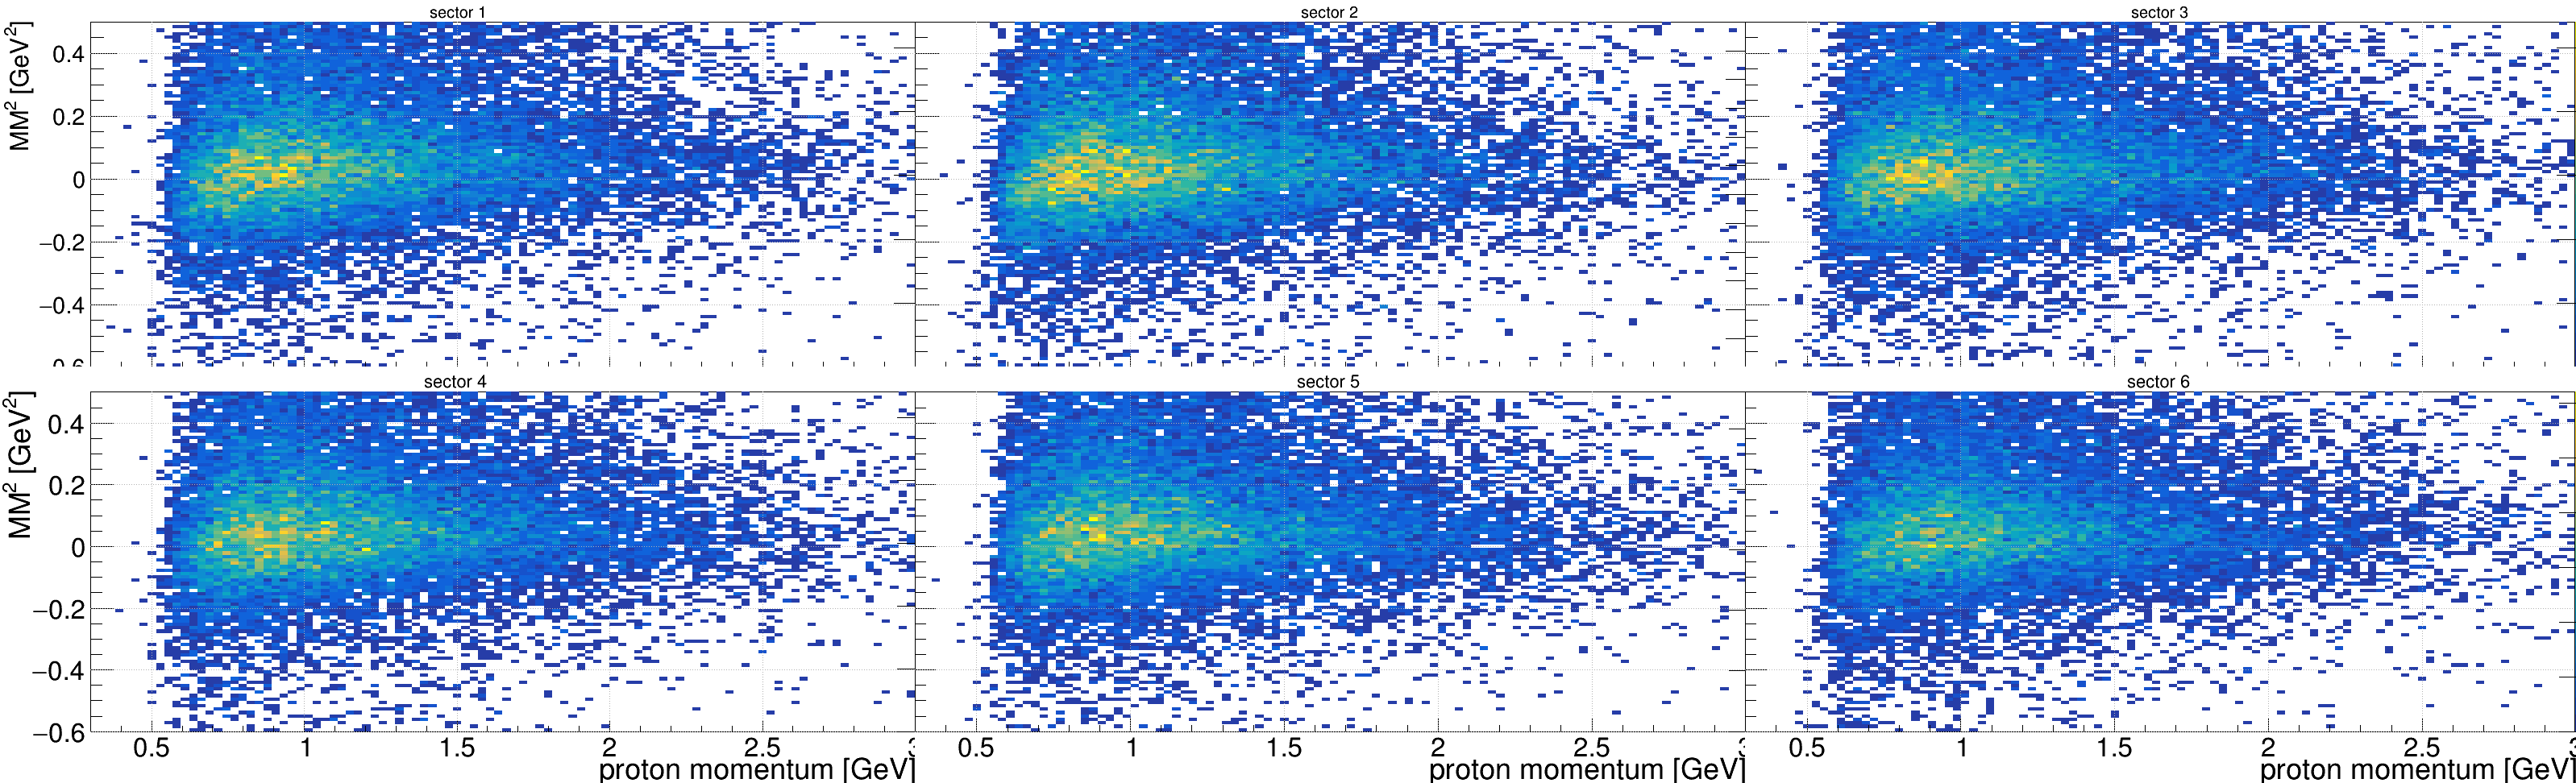

In [4]:
c1 = ROOT.TCanvas("c1","c1",3200,1000)
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)
c1.Draw()

for esec in range(1,7):
    c1.cd(esec).SetTopMargin(0.06)
    h2as[esec-1].Draw("colz")
c1.Print(f"../pdf/eppi0.eloss.effect.mm2vspp.{dsid}.pdf")

In [5]:
def fitslices(h2):
    setattr(h2, "gr", ROOT.TGraphErrors())
    for pm,h1 in zip(h2.pms, h2.h1s):
        f1 = ROOT.TF1("f1"+h1.GetName(), "gaus(0)+pol1(3)", -0.53,0.34)
        f1.SetLineWidth(1)
        f1.SetParameters(1,0,0.1,1,1)
        f1.SetParLimits(1,-0.4,0.1)
        f1.SetParLimits(2,0.01,0.21)
        h1.Fit(f1,"QR")
        mu,sig = f1.GetParameter(1), f1.GetParameter(2)
        f1.SetRange(mu-3*sig, mu+3*sig)
        h1.Fit(f1,"QR")
        h2.gr.SetPoint(h2.gr.GetN(), pm.GetValue(), f1.GetParameter(1))
        h2.gr.SetPointError(h2.gr.GetN()-1, 0, f1.GetParError(1))

c1s=[]
for sec in range(1,7):
    c1 = ROOT.TCanvas(f"c{sec}","canvas",2200,1000)
    #c1.Draw()
    c1s.append(c1)

    h2a,h2c,h2d = h2as[sec-1],h2cs[sec-1],h2ds[sec-1]

    fitslices(h2a)
    fitslices(h2c)
    fitslices(h2d)

    c1.Clear()
    c1.Divide(4,2,0,0)
    
    ipad = 0
    for pm,h1 in zip(h2a.pms,h2a.h1s):
        ipad+=1
        c1.cd(ipad)
        h1.Draw()
    #c1.Print(f"eppi0.MM2.eloss.effect.fits.sec{sec}.nocorr.{dsid}.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file ../pdf/eppi0.eloss.effect.mm2vspp.graph.outb.pdf has been created


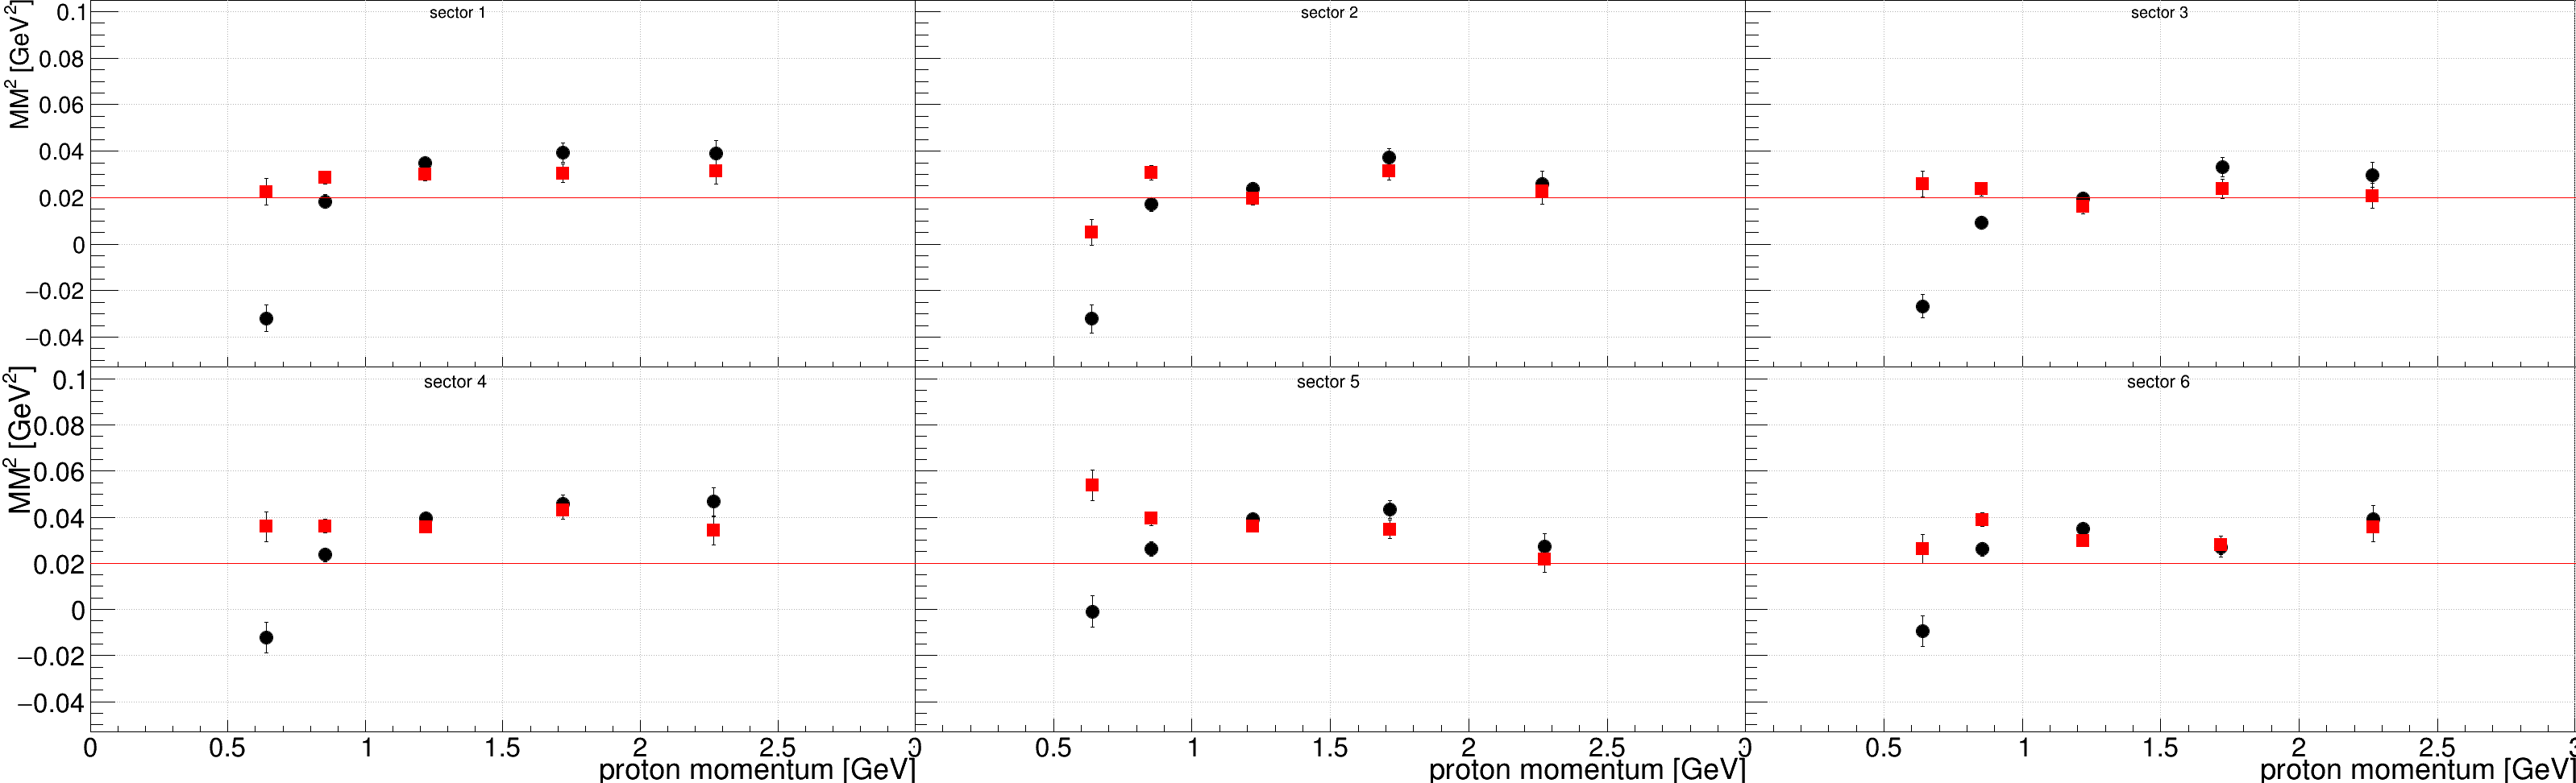

In [6]:
c1 = ROOT.TCanvas("c1","canvas",3200,1000)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

ll = ROOT.TLine()
ll.SetLineColor(2)

for sec in range(1,7):
    c1.cd(sec).DrawFrame(0,-0.212,3.2,0.075).SetTitle(f"sector {sec};proton momentum [GeV];MM^{{2}} [GeV^{{2}}]")
    if 'outb' in fname: c1.cd(sec).DrawFrame(0,-0.053,3,0.105).SetTitle(f"sector {sec};proton momentum [GeV];MM^{{2}} [GeV^{{2}}]")
    h2a,h2d = h2as[sec-1],h2ds[sec-1]

    h2a.gr.SetMarkerStyle(20)
    h2a.gr.Draw("P")

    h2c.gr.SetMarkerStyle(22)
    h2c.gr.SetMarkerColor(3)
    #h2c.gr.Draw("P")

    h2d.gr.SetMarkerStyle(21)
    h2d.gr.SetMarkerColor(2)
    h2d.gr.Draw("P")

    ll.DrawLine(0,0.02,3,0.02)
    
c1.Print(f"../pdf/eppi0.eloss.effect.mm2vspp.graph.{dsid}.pdf")